# London Smart Meters

The objective of this project is to predict the energy consumption in London that took part in the UK Power Networks’ Low Carbon London project from November 2011 to February 2014. The aim is to forecast energy consumption for these households, taking into account the different pricing structures, and analyzing the potential impact of dToU pricing on consumption patterns. This analysis can offer valuable insights into how consumers respond to varying energy pricing, which can inform future energy management strategies and policies.

# Import

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np
import missingno as msno
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

# Load Data

Four datasets were used in this project
- df_sample.csv
- df_tarrif.csv

The data is sourced from the [London data store](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households) and contains energy consumption readings in kWh, timestamps recorded at half-hour intervals, and unique identifiers for every household. The dataset is comprised of energy usage data for 5,567 London households who participated in the UK Power Networks-led Low Carbon London initiative between November 2011 and February 2014.

Within this dataset, there are two distinct customer groups. 	
- The first group consists of around 1,100 customers who experienced Dynamic Time of Use (dToU) energy pricing during the entirety of 2013. These customers received pricing signals one day in advance through Smart Meter In-Home Displays (IHDs) or text messages on their mobile phones. The pricing signals included High (67.20p/kWh), Low (3.99p/kWh), or normal (11.76p/kWh) rates, with specific timeframes for each rate.
- The remaining approximately 4,500 customers did not receive dToU tariffs and were instead on a flat rate tariff of 14.228pence/kWh

The orignal CSV file is approximately 10GB when unzipped and contains roughly 167 million rows.
My goal was to create a manageable dataset that maintains the integrity and distribution of the original data while preserving the proportion of custormer gruop; specifically tariff and acorn group.  This allows for accurate analysis and comparison between the two pricing plans while ensuring the computational efficiency of our methods. 

I employed a stratified random sampling technique to select 10 percent of the original dataset. This approach was chosen to ensure that the sample is representative of the population, particularly with regard to the key characteristic of interest: the pricing plan type.



In [2]:
file_paths = [
    'df_tariff.csv',
    'sample.csv']

dfs = [pd.read_csv(file_path, encoding='latin-1') for file_path in file_paths]

df_tariff, df_sample = dfs

In [3]:
df_sample.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn_grouped
0,MAC000041,Std,2012-01-01 00:00:00,0.309,Adversity
1,MAC000041,Std,2012-01-01 00:30:00,0.174,Adversity
2,MAC000041,Std,2012-01-01 01:00:00,0.147,Adversity
3,MAC000041,Std,2012-01-01 01:30:00,0.069,Adversity
4,MAC000041,Std,2012-01-01 02:00:00,0.061,Adversity


- Acorn is a geodemographic segmentation system that provides insights into customer demographics and lifestyles.
- In this dataset, consumers are classified into three categories: Affluent, Comfortable, and Adversity.

In [4]:
df_tariff.head()

,TariffDateTime,Tariff
0,1/1/2013 0:00,Normal
1,1/1/2013 0:30,Normal
2,1/1/2013 1:00,Normal
3,1/1/2013 1:30,Normal
4,1/1/2013 2:00,Normal


# Data Wrangling

In [5]:
df = df_sample.copy()

In [6]:
# Convert the 'DateTime' column to datetime objects
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [7]:
# Remove duplicate rows from the DataFrame to ensure data integrity
df = df.drop_duplicates()

In [8]:
# Rename column
df = df.rename(columns={'KWH/hh (per half hour) ': 'Usage'})

In [9]:
# Extract the time from the 'DateTime' column, convert it to a string, and truncate it to the "HH:MM" format.
df['Time'] = df['DateTime'].dt.time.astype(str).str.slice(0, 5)
df['Time'].unique()

array(['00:00', '00:30', '01:00', '01:30', '02:00', '02:30', '03:00',
       '03:30', '04:00', '04:30', '05:00', '05:30', '06:00', '06:30',
       '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00',
       '10:30', '11:00', '11:30', '12:00', '12:30', '13:00', '13:30',
       '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00',
       '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
       '21:00', '21:30', '22:00', '22:30', '23:00', '23:30', '15:13',
       '15:15', '15:14'], dtype=object)

There are some unique times ('15:13', '15:14', '15:15') that do not align with the expected half-hour intervals. These could be anomalies or errors in the data that might need further investigation. 

In [10]:
# Filter the rows that contain the unexpected time values ('15:13', '15:14', '15:15')
mask = (df['DateTime'].dt.minute == 0) | (df['DateTime'].dt.minute == 30)
unusual = df[~mask]
unusual

,LCLid,stdorToU,DateTime,Usage,Acorn_grouped,Time
16920,MAC000041,Std,2012-12-18 15:13:43,Null,Adversity,15:13
54808,MAC000053,Std,2012-12-18 15:13:44,Null,Comfortable,15:13
92704,MAC000086,Std,2012-12-18 15:13:48,Null,Affluent,15:13
130599,MAC000110,Std,2012-12-18 15:13:51,Null,Affluent,15:13
168445,MAC000129,Std,2012-12-18 15:13:53,Null,Affluent,15:13
206197,MAC000148,Std,2012-12-18 15:13:26,Null,Comfortable,15:13
244090,MAC000156,Std,2012-12-18 15:13:27,Null,Comfortable,15:13
278113,MAC000299,Std,2012-12-18 15:15:06,Null,Affluent,15:15
312087,MAC000310,Std,2012-12-18 15:15:07,Null,Adversity,15:15
346692,MAC000340,Std,2012-12-18 15:15:11,Null,Comfortable,15:15


The rows with the unexpected time values ('15:13', '15:14', '15:15') share some common characteristics
- All the readings were taken on December 18, 2012, around the 15:15 half-hour mark. 
- For all these rows, the 'Usage' column contains 'Null,' indicating that no valid energy consumption readings were recorded at those times. 

This suggests a possible systematic issue that occurred at this specific time across multiple households. The cause could be a data collection error, a system reset, or a temporary malfunction.

In [11]:
# Convert the 'Usage' column to numeric type, coercing any errors (non-numeric values) to NaN
df['Usage'] = pd.to_numeric(df['Usage'], errors='coerce')

In [12]:
df.isna().sum()

LCLid             0
stdorToU          0
DateTime          0
Usage            54
Acorn_grouped     0
Time              0
dtype: int64

There are 54 records in the dataset where the DateTime values do not correspond to the expected 00 or 30-minute intervals. This number is the same as the number of entries in the ‘Usage’ column with a value of “Null”.
These rows are filtered out from the data and only the standard half-hourly readings are considered for consumption analysis.

In [13]:
# Keep only the rows with usual half-hour interval readings
df = df[mask]
df['Time'].unique()

array(['00:00', '00:30', '01:00', '01:30', '02:00', '02:30', '03:00',
       '03:30', '04:00', '04:30', '05:00', '05:30', '06:00', '06:30',
       '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00',
       '10:30', '11:00', '11:30', '12:00', '12:30', '13:00', '13:30',
       '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00',
       '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
       '21:00', '21:30', '22:00', '22:30', '23:00', '23:30'], dtype=object)

## Missing Values

There is no missing data in df_sample because if there are no readings, they are not included. To confirm this, compute the total number of recordings for each household.

In [14]:
df_sample.isna().sum()

LCLid                      0
stdorToU                   0
DateTime                   0
KWH/hh (per half hour)     0
Acorn_grouped              0
dtype: int64

In [15]:
# Group by 'stdorToU' and 'LCLid' and count the number of DateTime entries
size = df.groupby(['stdorToU','LCLid'])['DateTime'].size().reset_index()

# Rename the resulting size column to 'total_readings'
size.rename(columns={'DateTime':'total_readings'}, inplace=True)

# Get the first entry for each 'LCLid' to find when the recording started
first = df.groupby(['LCLid']).first().reset_index()

# Get the last entry for each 'LCLid' to find when the recording ended
last = df.groupby(['LCLid']).last().reset_index()

# Create a new dataframe with the 'LCLid', 'stdorToU', and start 'DateTime'
df_total_reading = first[['LCLid','stdorToU','DateTime']].rename(columns={'DateTime':'DateTime_start'})

# Merge with the end 'DateTime' to have both start and end times in one dataframe
df_total_reading = pd.merge(df_total_reading, last[['LCLid','stdorToU','DateTime']].rename(columns={'DateTime':'DateTime_end'}),
                            how='inner', on=['LCLid','stdorToU'])

# Merge the dataframe with the 'size' dataframe to include the total number of readings for each 'LCLid'
df_total_reading = pd.merge(df_total_reading, size, how='left', on=['LCLid','stdorToU'])

# Display the resulting dataframe
df_total_reading


,LCLid,stdorToU,DateTime_start,DateTime_end,total_readings
0,MAC000041,Std,2012-01-01 00:00:00,2014-02-28,37853
1,MAC000053,Std,2012-01-01 00:00:00,2014-02-28,37859
2,MAC000086,Std,2012-01-01 00:00:00,2014-02-28,37872
3,MAC000110,Std,2012-01-01 00:00:00,2014-02-28,37863
4,MAC000129,Std,2012-01-01 00:00:00,2014-02-28,37680
5,MAC000148,Std,2012-01-01 00:00:00,2014-02-28,37865
6,MAC000156,Std,2012-01-01 00:00:00,2014-02-28,37866
7,MAC000299,Std,2012-03-02 14:00:00,2014-02-28,33186
8,MAC000310,Std,2012-03-05 15:00:00,2014-02-28,34716
9,MAC000328,ToU,2012-03-07 09:30:00,2014-02-28,34674


The longest possible data records for a household, assuming there are no missing readings and that recordings were continuous from the first to the last day, would be 37,872 readings.

<Axes: >

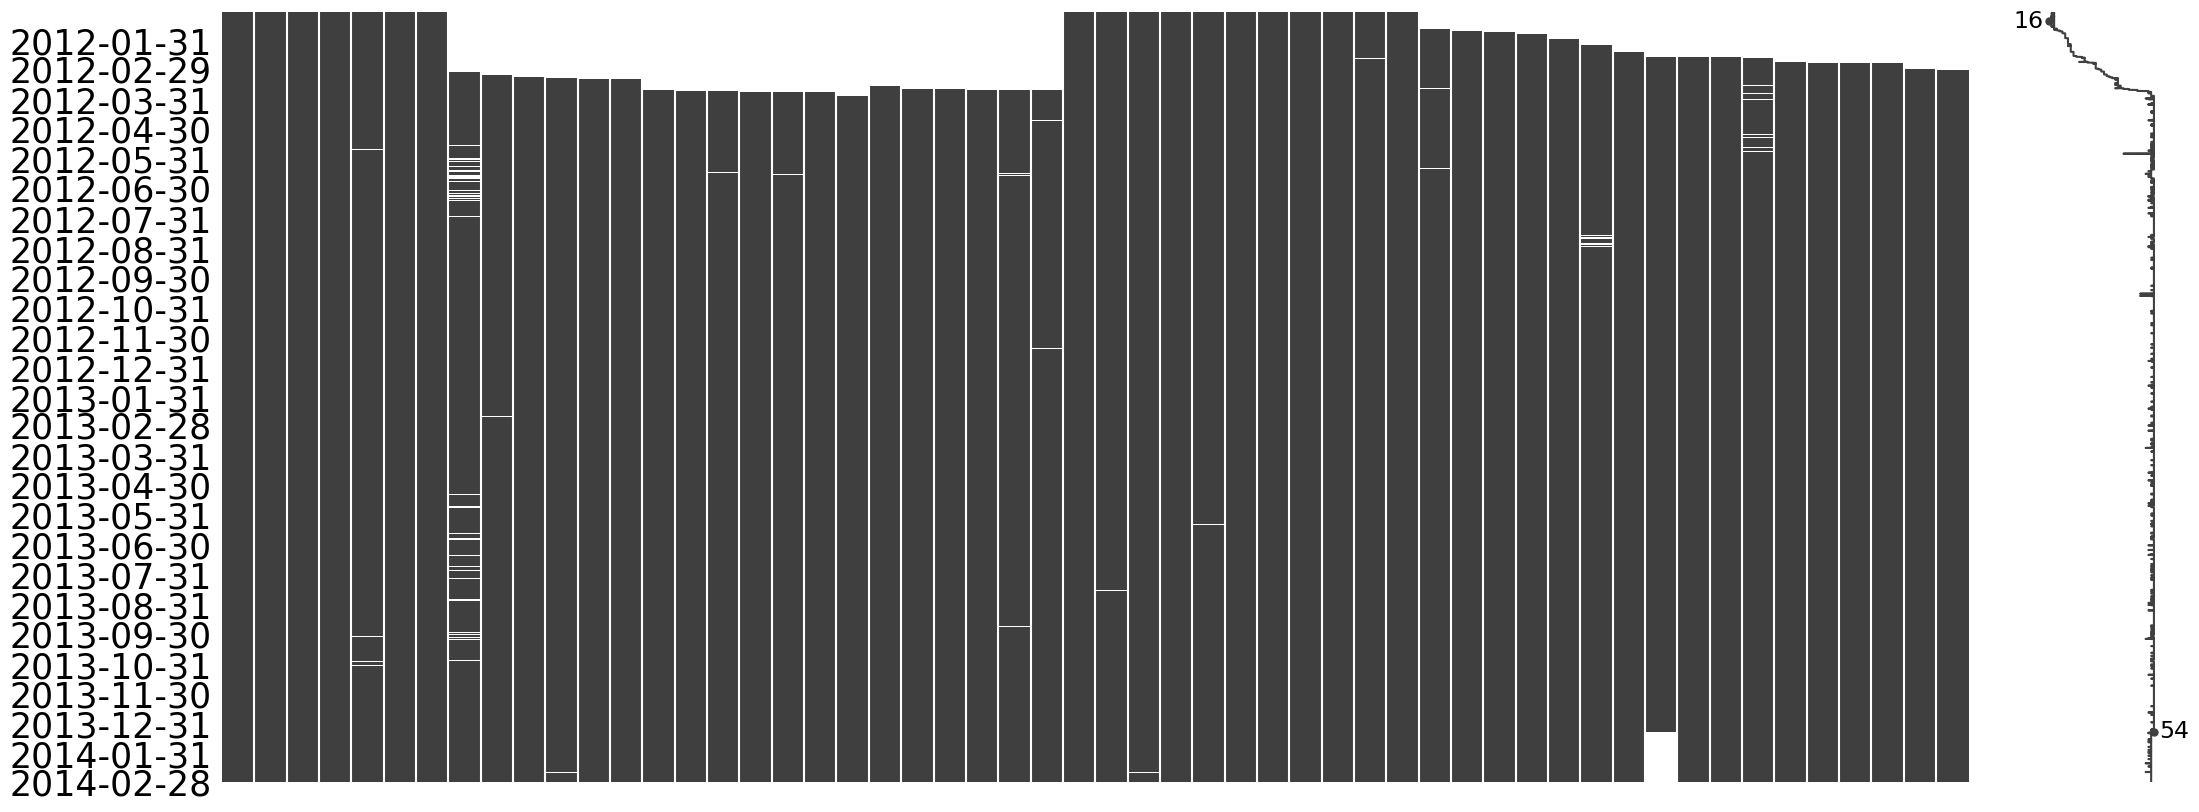

In [16]:
# Visualize missing data
plot_df = pd.pivot_table(df, index='DateTime', columns='LCLid', values='Usage')
msno.matrix(plot_df, freq='M', fontsize=20)

All time series are not perfectly aligned. Additionally, many time series contain smaller white lines that represent actual missing values.

In [17]:
# Creating a date range for the complete datetime index
date = pd.date_range(start='2012-01-01', end='2014-02-28', freq='30min')

# Converting the date range to a DataFrame
df_date = pd.DataFrame(date, columns=['DateTime'])

# Getting unique LCLid values
lclid = df['LCLid'].unique()

# Creating a MultiIndex from the product of LCLid and DateTime
index = pd.MultiIndex.from_product([lclid, df_date['DateTime']], names=['LCLid', 'DateTime'])

# Creating a DataFrame with the complete index
df_full = pd.DataFrame(index=index).reset_index()

# Merging with the original dataframe to fill in available data
df_full = df_full.merge(df, on=['LCLid', 'DateTime'], how='left')

# Getting unique stdorToU for each LCLid
unique_stdorToU = df.groupby('LCLid')['stdorToU'].first()

# Filling in the stdorToU in the full dataframe
df_full['stdorToU'] = df_full.groupby('LCLid')['stdorToU'].transform(lambda x: x.fillna(unique_stdorToU[x.name]))

# Displaying the head of the full dataframe
df_full.head()

,LCLid,DateTime,stdorToU,Usage,Acorn_grouped,Time
0,MAC000041,2012-01-01 00:00:00,Std,0.309,Adversity,00:00
1,MAC000041,2012-01-01 00:30:00,Std,0.174,Adversity,00:30
2,MAC000041,2012-01-01 01:00:00,Std,0.147,Adversity,01:00
3,MAC000041,2012-01-01 01:30:00,Std,0.069,Adversity,01:30
4,MAC000041,2012-01-01 02:00:00,Std,0.061,Adversity,02:00


In [18]:
df_full['Date'] = df_full['DateTime'].dt.date
df_full['Date'] = pd.to_datetime(df_full['Date'], format='%Y-%m-%d')
df_full['Time'] = df_full['DateTime'].dt.time.astype(str).str.slice(0, 5)
df_full.isna().sum()

LCLid                 0
DateTime              0
stdorToU              0
Usage            108456
Acorn_grouped    108456
Time                  0
Date                  0
dtype: int64

- Dealing with missing values in time series data can be done through various techniques. These include forward and backward filling, linear and spline interpolation, and seasonal decomposition with interpolation. The choice of method depends on the characteristics of the time series and the extent of the gaps. 

- Before proceeding with the imputation of missing values, select one household for further investigation.

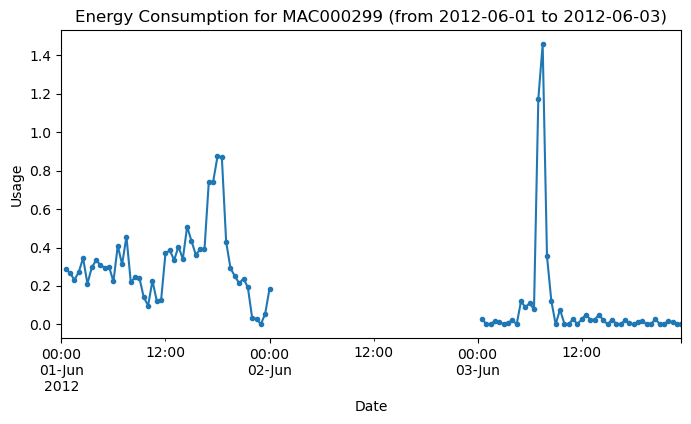

In [21]:
# Filtering the data specifically for the household with LCLid as 'MAC000299' bewteen 2012-5-31 and 2012-6-3
df_filtered = df_full[(df_full['LCLid'] == 'MAC000299') &
                 (df_full['Date'] >= pd.to_datetime('2012-6-1')) &
                 (df_full['Date'] <= pd.to_datetime('2012-6-3'))]

ax = df_filtered.plot(x='DateTime', y='Usage', marker=".", figsize=[8, 4], legend=None)

ax.set_title('Energy Consumption for MAC000299 (from 2012-06-01 to 2012-06-03)')
ax.set_ylabel('Usage')
ax.set_xlabel('Date')
plt.show()

### Linear Interpolation

In [22]:
df_filtered['Usage_interpolated'] =  df_filtered['Usage'].interpolate(method="linear")

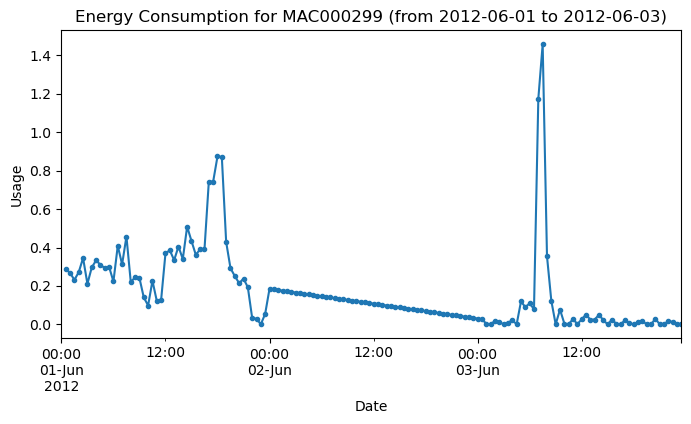

In [23]:
ax = df_filtered.plot(x='DateTime', y='Usage_interpolated', marker=".", figsize=[8, 4], legend=None)

ax.set_title('Energy Consumption for MAC000299 (from 2012-06-01 to 2012-06-03)')
ax.set_ylabel('Usage')
ax.set_xlabel('Date')
plt.show()

Obviously, linear interpolation is not a good choice for time series data with longer gaps.

### Seasonal Decomposition and Interpolation

In [26]:
stl = STL(df_filtered['Usage_interpolated'].dropna(), period=48)
res = stl.fit()
seasonal_component = res.seasonal

In [28]:
df_deseasonalised = df_filtered['Usage'] - seasonal_component
df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")
df_imputed = df_deseasonalised_imputed + seasonal_component
df_imputed = df_imputed.to_frame()
df_imputed = df_imputed.rename(columns={0: 'Usage'})

In [29]:
df_filtered['seasonal_imputed'] = df_imputed

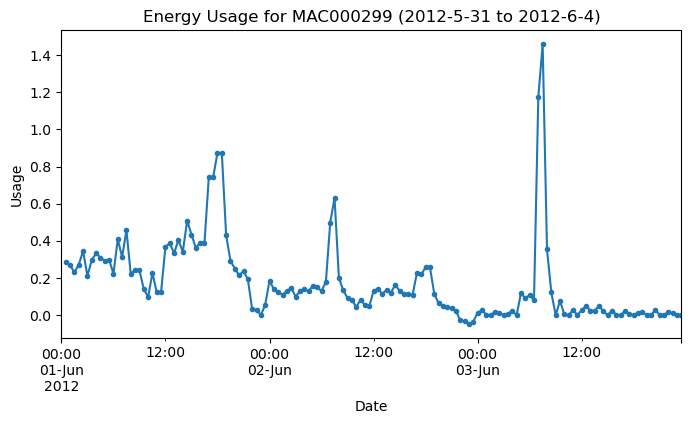

In [32]:
ax = df_filtered.plot(x='DateTime', y='seasonal_imputed', marker=".", figsize=[8, 4], legend=None)

ax.set_title('Energy Usage for MAC000299 (2012-5-31 to 2012-6-4)')
ax.set_ylabel('Usage')
ax.set_xlabel('Date')
plt.show()

# Imputation

In [33]:
date = pd.date_range(start='2012-01-01', end='2014-02-28', freq='30min')
df_date = pd.DataFrame(date, columns=['DateTime'])
lclid = df['LCLid'].unique()

index = pd.MultiIndex.from_product([lclid, df_date['DateTime']], names=['LCLid', 'DateTime'])

df_full = pd.DataFrame(index=index).reset_index()
df_full = df_full.merge(df, on=['LCLid', 'DateTime'], how='left')

unique_stdorToU= df.groupby('LCLid')['stdorToU'].first()
df_full['stdorToU'] = df_full.groupby('LCLid')['stdorToU'].transform(lambda x: x.fillna(unique_stdorToU[x.name]))

df_full.head()

,LCLid,DateTime,stdorToU,Usage,Acorn_grouped,Time
0,MAC000041,2012-01-01 00:00:00,Std,0.309,Adversity,00:00
1,MAC000041,2012-01-01 00:30:00,Std,0.174,Adversity,00:30
2,MAC000041,2012-01-01 01:00:00,Std,0.147,Adversity,01:00
3,MAC000041,2012-01-01 01:30:00,Std,0.069,Adversity,01:30
4,MAC000041,2012-01-01 02:00:00,Std,0.061,Adversity,02:00


In [34]:
df_full['Date'] = df_full['DateTime'].dt.date
df_full['Date'] = pd.to_datetime(df_full['Date'], format='%Y-%m-%d')
df_full['Time'] = df_full['DateTime'].dt.time.astype(str).str.slice(0, 5)

In [37]:
def impute_missing_values(group):
    group = group.set_index('DateTime')

    group['Usage_interpolated'] = group['Usage'].interpolate(method="linear")
    group = group.dropna(subset=['Usage_interpolated'])
    stl = STL(group['Usage_interpolated'], period=48)
    res = stl.fit()

    deseasonalised = group['Usage_interpolated'] - res.seasonal
    deseasonalised_imputed = deseasonalised.interpolate(method="linear")

    imputed = deseasonalised_imputed + res.seasonal

    imputed_df = imputed.to_frame()
    imputed_df = imputed_df.rename(columns={0: 'Usage_imputed'})
    group['Usage_imputed'] = imputed_df['Usage_imputed']

    return group

In [38]:
df_imputed = df_full.groupby('LCLid').apply(impute_missing_values)

df_imputed.head()

LCLid stdorToU  Usage Acorn_grouped   Time  \
LCLid     DateTime                                                              
MAC000041 2012-01-01 00:00:00  MAC000041      Std  0.309     Adversity  00:00   
          2012-01-01 00:30:00  MAC000041      Std  0.174     Adversity  00:30   
          2012-01-01 01:00:00  MAC000041      Std  0.147     Adversity  01:00   
          2012-01-01 01:30:00  MAC000041      Std  0.069     Adversity  01:30   
          2012-01-01 02:00:00  MAC000041      Std  0.061     Adversity  02:00   

                                    Date  Usage_interpolated  Usage_imputed  
LCLid     DateTime                                                           
MAC000041 2012-01-01 00:00:00 2012-01-01               0.309          0.309  
          2012-01-01 00:30:00 2012-01-01               0.174          0.174  
          2012-01-01 01:00:00 2012-01-01               0.147          0.147  
          2012-01-01 01:30:00 2012-01-01               0.069          0.069  
          2012-01-01 02:00:00 2012-01-01               0.061          0.061

In [39]:
df_imputed = df_imputed.droplevel('LCLid').reset_index()

<Axes: >

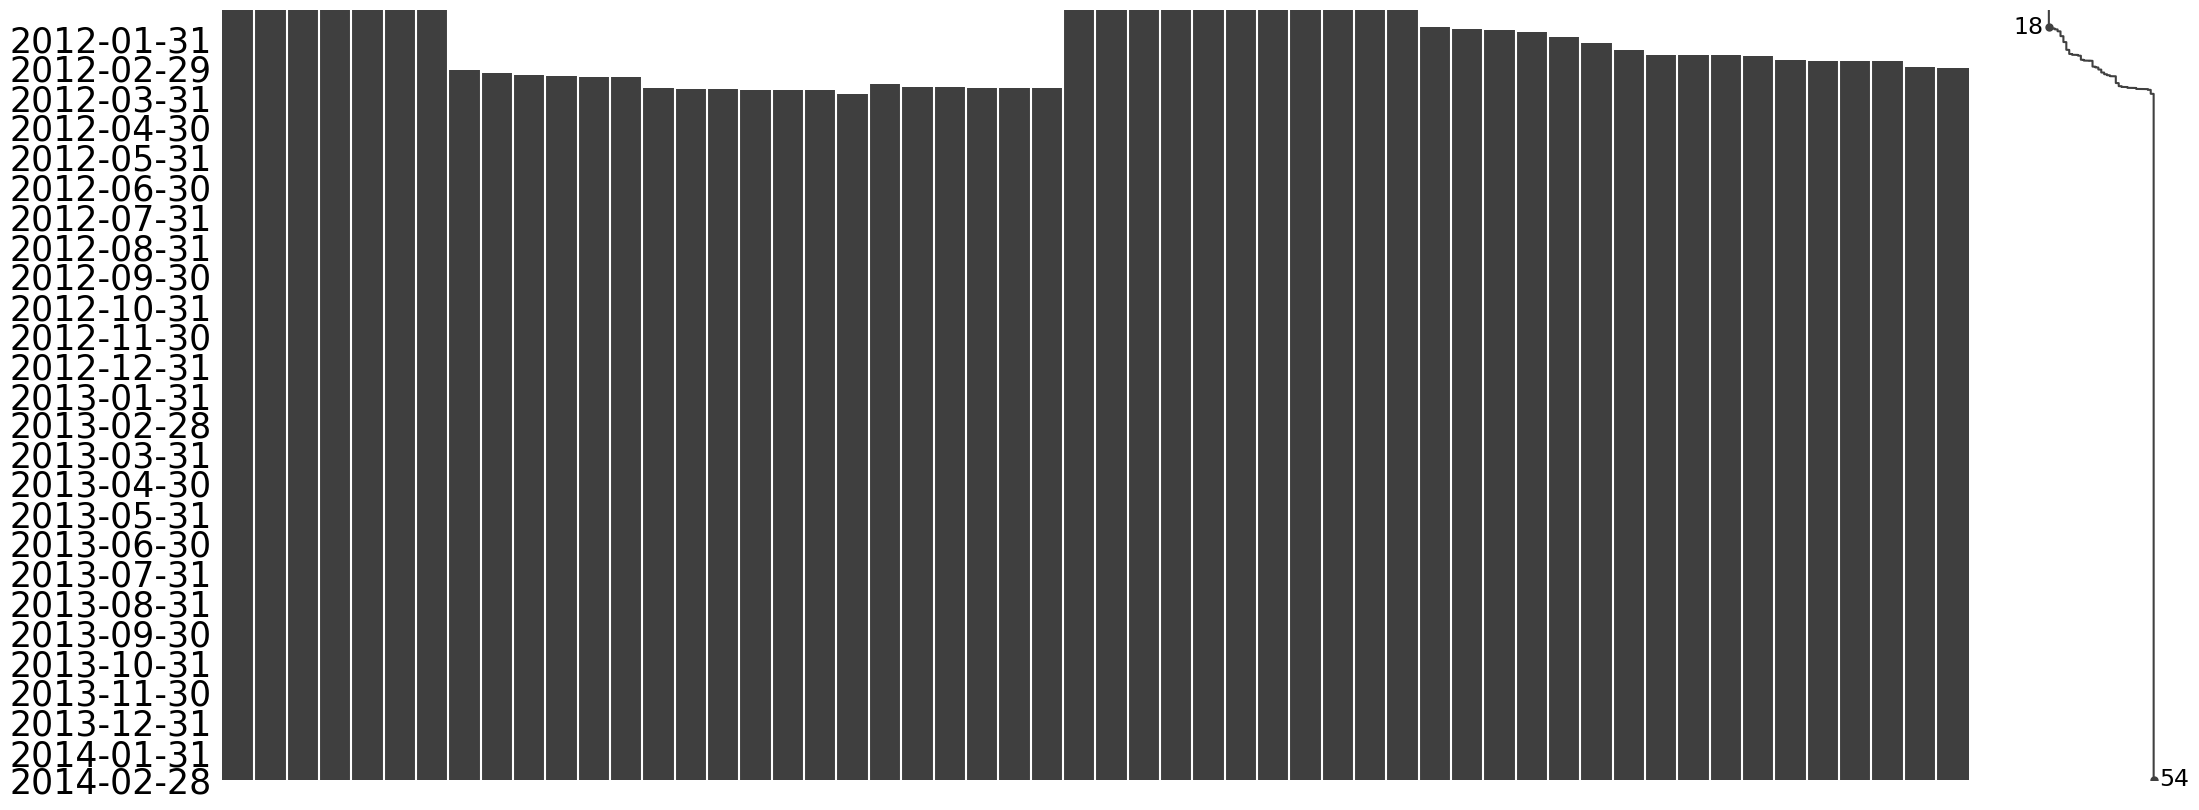

In [40]:
plot_df = pd.pivot_table(df_imputed, index='DateTime', columns='LCLid', values='Usage_imputed')
msno.matrix(plot_df, freq='M', fontsize=20)

# Merging Data

In [43]:
df_tariff = df_tariff.rename(columns={'TariffDateTime': 'DateTime'})

In [47]:
df_tariff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  17520 non-null  object
 1   Tariff    17520 non-null  object
dtypes: object(2)
memory usage: 273.9+ KB


In [49]:
df_tariff['DateTime'] = pd.to_datetime(df_tariff['DateTime'])

In [50]:
df_merge = pd.merge(df_imputed, df_tariff, on ='DateTime', how = 'left' )

In [52]:
df_merge.to_csv('df_merge.csv', index=False)